In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [235]:
df = pd.read_csv("stroke data.csv")
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


In [236]:
df.describe()

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,metric_5,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000,43400.000000
mean,21700.500000,42.261212,0.093571,0.047512,104.482750,28.605038,0.289931,97.526855,104.482750,0.018041
std,12528.645178,23.438911,0.291235,0.212733,43.111751,7.770020,0.453735,1.466703,43.111751,0.133103
min,1.000000,-10.000000,0.000000,0.000000,55.000000,10.100000,0.000000,87.420000,55.000000,0.000000
25%,10850.750000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000,96.590000,77.540000,0.000000
50%,21700.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000,97.610000,91.580000,0.000000
75%,32550.250000,60.000000,0.000000,0.000000,112.070000,32.900000,1.000000,98.700000,112.070000,0.000000
max,43400.000000,1000.000000,1.000000,1.000000,291.050000,97.600000,1.000000,100.000000,291.050000,1.000000


In [237]:
df.isnull().sum()

id                    0
gender                0
age                   0
married               0
hypertension          0
heart_disease         0
occupation            0
residence             0
metric_1              0
metric_2           1462
metric_3              0
metric_4              0
metric_5              0
smoking_status    13292
stroke                0
dtype: int64

In [238]:
# Process data by dropping uneccessary columns, removing incorrect values(age = -10); switch columns to numerical data
df.drop("id", axis = 1, inplace = True)
df.drop(df[(df["age"] < 0)].index, inplace = True)

# fillna(0) returns higher accuracy than dropna() for smoking_status
# Some issue where fillna() does not work on metric_2, so just dropna() after fillna(0)
df["smoking_status"].fillna(0)

labeler = LabelEncoder()
c = df.select_dtypes(include = "object").columns
df[c] = df[c].apply(labeler.fit_transform)

df.dropna(inplace = True)
df.isnull().sum()

gender            0
age               0
married           0
hypertension      0
heart_disease     0
occupation        0
residence         0
metric_1          0
metric_2          0
metric_3          0
metric_4          0
metric_5          0
smoking_status    0
stroke            0
dtype: int64

<AxesSubplot:>

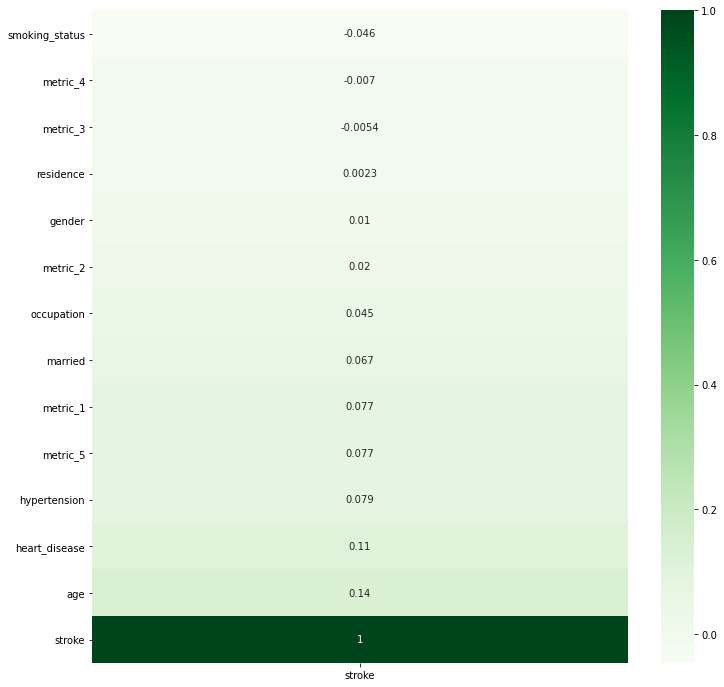

In [239]:
#Find best variables to use in model
plt.figure(figsize=(12,12))
sns.heatmap(df.corr()[["stroke"]].sort_values(by = "stroke"), annot = True, cmap="Greens")

In [470]:
# Split data
best_variables = [k for k, v in df.corr()["stroke"].items() if v > 0.00 and k != "stroke"]
X = df[best_variables]
y = df["stroke"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state = 42)

# Balance Data!! Smote achieved slightly higher scores than RandomOverSampler, so went with Smote

# oversample = RandomOverSampler(sampling_strategy="minority")
# Xtrain, ytrain = oversample.fit_resample(Xtrain, ytrain)
# Xtest, ytest = oversample.fit_resample(Xtest, ytest)

smote=SMOTE()
Xtrain, ytrain=smote.fit_resample(Xtrain, ytrain)
Xtest, ytest=smote.fit_resample(Xtest, ytest)

#Create and train model
pipe = Pipeline([("std", StandardScaler()), ("lr", LogisticRegression())])
pipe.fit(Xtrain, ytrain)

# Make predictions
ypred = pipe.predict(Xtest)

# Score model
print("Accuracy:", pipe.score(Xtest, ytest))
print("\nClassification report:\n", classification_report(ytest, ypred))
pd.DataFrame(confusion_matrix(ytest, ypred))

Accuracy: 0.8314796905222437

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      8272
           1       0.80      0.89      0.84      8272

    accuracy                           0.83     16544
   macro avg       0.84      0.83      0.83     16544
weighted avg       0.84      0.83      0.83     16544



,0,1
0,6420,1852
1,936,7336


In [474]:
# Second Model, RandomForestClassifier returned low scores so using XGBoost

# Create model
model = xgb.XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, objective="binary:logistic")

# Fit model
model.fit(Xtrain, ytrain)

# Make predictions
ypred = model.predict(Xtest)

# Score model
print("Accuracy:", model.score(Xtest, ytest))
print("\nClassification report:\n", classification_report(ytest, ypred))
pd.DataFrame(confusion_matrix(ytest, ypred))

Accuracy: 0.9509792069632496

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      8272
           1       0.99      0.91      0.95      8272

    accuracy                           0.95     16544
   macro avg       0.95      0.95      0.95     16544
weighted avg       0.95      0.95      0.95     16544



,0,1
0,8192,80
1,731,7541


In [475]:
# With more time, I probably could have increased the models performance through further hyperparameter tuning
# I would have used RandomSearchCV or GridSearchCV to maximize the scores
# I also may have experimented with different ways of cleaning the data
# For example, metric_2 had missing data in places.
# I was thinking about potentially replacing N/A values in metric_2 with the mean of metric_2 to see effect.
# I also thought about adding columns to show if a patient was multiple standard deviations off the avg metric
# Another thought was to test XGBoost with with original dataset INCLUDING N/A values since it is able to handle missing data